In [92]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [93]:
results_path = Path("../../../results/classifiers")
STEP = "hp_search"

In [94]:
varying_hyperparameter_names = ["batch_size", "head_learning_rate", "l2_weight", "warmup_proportion"]

## Granular attributes classification

### Economic attributes

In [95]:
task = "economic_attributes_classification"
label_classes = [
    'economic__class_membership',
    'economic__education_level',
    'economic__occupation_profession',
    'economic__employment_status',
    'economic__income_wealth_economic_status',
    'economic__ecology_of_group',
]

#### Best hyperparameters?

In [96]:
trial_results_files = list(results_path.glob(f"{task}/**/{STEP}/**/trial_results.csv"))

In [97]:
trial_results = pd.concat(
    {f.parts[-4:-1]: pd.read_csv(f) for f in trial_results_files},
)
trial_results.reset_index(level=[0, 1, 2], names=["model", "strategy", "fold"], inplace=True)

In [132]:
trial_results_sum = trial_results.groupby(["model", "strategy", *varying_hyperparameter_names])["f1"].mean().reset_index()

In [134]:
# get row with max F1 for each model and strategy
trial_results_sum.groupby(["model", "strategy"])[["f1", *varying_hyperparameter_names]].apply(lambda x: x.loc[x["f1"].idxmax()]).reset_index()

,model,strategy,f1,batch_size,head_learning_rate,l2_weight,warmup_proportion
0,google--embeddinggemma-300m,mention_text,0.361435,"(8, 4)",0.003,0.010,0.10
1,nomic-ai--modernbert-embed-base,mention_text,0.710582,"(16, 16)",0.003,0.015,0.15
2,sentence-transformers--all-mpnet-base-v2,mention_text,0.759524,"(16, 4)",0.030,0.015,0.10


#### Model evaluation

In [135]:
model = "sentence-transformers--all-mpnet-base-v2"

In [137]:
results_dir = results_path / task / STEP / "setfit" / model

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

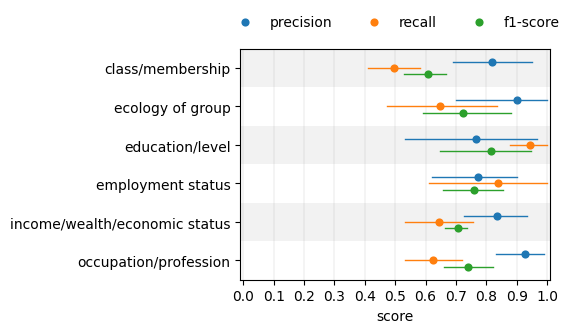

In [162]:
# TODO (maybe): compute CIs from folds
metrics = ["weighted avg", "macro avg", "micro avg", "samples avg"]
pdat = df.query("what not in @metrics").copy()
pdat["what"] = pdat["what"]\
    .str.replace("economic__", "")\
    .str.replace("_of_", " of ")\
    .str.replace("_status", " status")\
    .str.replace("_", "/")

pdat = pdat.melt(id_vars=["what", "fold"], value_vars=["precision", "recall", "f1-score"], var_name="metric", value_name="value")

plt.figure(figsize=(4, 3))

# add grey horizontal stripes at alternating y positions
for i in range(pdat.what.nunique()):
    if i % 2 == 0:
        plt.gca().axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

ls = '-' # (0, (5, 10))
plt.grid(axis="x", which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="what",
    x="value",

    hue="metric",
    dodge=1/3,
    #color='black',
    
    linestyles='none',
    scale=2/3,
    errwidth=1,
    # markersize=3,

    errorbar='ci',
    # capsize=.05,
    # err_kws={'linewidth': .75},

    # legend=False,
    seed=42
)
# add bold title and labels
# plt.title(metric, fontweight='bold')
plt.xlabel("score")
plt.ylabel("")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.1, 0.1))

# place legend below plot
plt.legend(title=None, bbox_to_anchor=(0.5, +1.2), loc='upper center', ncol=3, frameon=False)
# plt.tight_layout()

plt.show()

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [155]:
key_cols = ['fold', 'mention_id', 'text', 'mention', 'span']

preds_df = pd.concat({
    fp.parts[-4:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2], names=["model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [156]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [157]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [159]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for a, tmp in error_rates_df.groupby('attribute'):
    print(f"\033[1m{a}\033[0m")
    for l, subdf in tmp.groupby('label'):
        # print attribute name in bold
        print(f"  ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
        for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
            highlighted_text = highlight(row['text'], row['mention'])
            print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
        print()

economic__class_membership
  ~> false positives
  -  92436_200509-360961-1 (1.00):  Ordinary people who practice sports have fewer healthcare expenditures, fewer pathologies and better development prospects.
  -  92436_200509-360932-4 (1.00):  The rich are the less rich, the stronger the weaker.
  -   42420_201710-19668-1 (1.00):  That agricultural subsidies benefit not primarily the active farmers, but public bodies and large commercial and economic enterprises.
  -  13230_198709-183559-2 (1.00):  The weak groups need to have their livelihoods significantly improved and the wealthy groups need to contribute more to the community.

  ~> false negatives
  -  14820_196603-197146-2 (1.00):  For example, when one asks a representative of the center why they always vote against the interests of the weaker part of the people, they answer, the state has a shortage of money so the main objects must be financed in the first place small farmers we ask if it belongs to the most important expenses

### Non-economic attributes

In [163]:
task = "noneconomic_attributes_classification"
label_classes = [
    'noneconomic__age',
    'noneconomic__crime',
    'noneconomic__ethnicity',
    'noneconomic__family',
    'noneconomic__gender_sexuality',
    'noneconomic__health',
    'noneconomic__nationality',
    'noneconomic__place_location',
    'noneconomic__religion',
    'noneconomic__shared_values_mentalities',
]

#### Best hyperparameters?

In [164]:
trial_results_files = list(results_path.glob(f"{task}/**/{STEP}/**/trial_results.csv"))

In [165]:
trial_results = pd.concat(
    {f.parts[-4:-1]: pd.read_csv(f) for f in trial_results_files},
)
trial_results.reset_index(level=[0, 1, 2], names=["model", "strategy", "fold"], inplace=True)

In [166]:
trial_results_sum = trial_results.groupby(["model", "strategy", *varying_hyperparameter_names])["f1"].mean().reset_index()

In [167]:
# get row with max F1 for each model and strategy
trial_results_sum.groupby(["model", "strategy"])[["f1", *varying_hyperparameter_names]].apply(lambda x: x.loc[x["f1"].idxmax()]).reset_index()

,model,strategy,f1,batch_size,head_learning_rate,l2_weight,warmup_proportion
0,google--embeddinggemma-300m,mention_text,0.760465,"(16, 4)",0.0001,0.010,0.10
1,nomic-ai--modernbert-embed-base,mention_text,0.805471,"(16, 16)",0.0300,0.015,0.10
2,sentence-transformers--all-mpnet-base-v2,mention_text,0.839831,"(32, 4)",0.0100,0.010,0.15


#### Model evaluation

In [168]:
model = "sentence-transformers--all-mpnet-base-v2"

In [169]:
results_dir = results_path / task / STEP / "setfit" / model

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

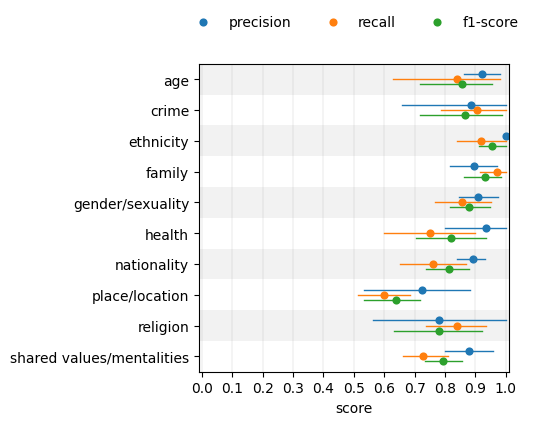

In [180]:
# TODO (maybe): compute CIs from folds
metrics = ["weighted avg", "macro avg", "micro avg", "samples avg"]
pdat = df.query("what not in @metrics").copy()
pdat["what"] = pdat["what"]\
    .str.replace("noneconomic__", "")\
    .str.replace("shared_", "shared ")\
    .str.replace("_", "/")

pdat = pdat.melt(id_vars=["what", "fold"], value_vars=["precision", "recall", "f1-score"], var_name="metric", value_name="value")

n_ys = pdat.what.nunique()
plt.figure(figsize=(4, n_ys/2.5))

# add grey horizontal stripes at alternating y positions
for i in range(n_ys):
    if i % 2 == 0:
        plt.gca().axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

ls = '-' # (0, (5, 10))
plt.grid(axis="x", which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="what",
    x="value",

    hue="metric",
    dodge=1/3,
    #color='black',
    
    linestyles='none',
    scale=2/3,
    errwidth=1,
    # markersize=3,

    errorbar='ci',
    # capsize=.05,
    # err_kws={'linewidth': .75},

    # legend=False,
    seed=42
)
# add bold title and labels
# plt.title(metric, fontweight='bold')
plt.xlabel("score")
plt.ylabel("")
plt.xlim(-0.01, 1.01)
plt.xticks(np.arange(0, 1.1, 0.1))

# place legend below plot
plt.legend(title=None, bbox_to_anchor=(0.5, +1.2), loc='upper center', ncol=3, frameon=False)
# plt.tight_layout()

plt.show()

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [181]:
key_cols = ['fold', 'mention_id', 'text', 'mention', 'span']

preds_df = pd.concat({
    fp.parts[-4:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2], names=["model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [182]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [184]:
# TODO: error rates don't make senses with one classifier and distinct eval (test) sets per fold
error_rates_df.error.value_counts()

error
0.0    5856
1.0     144
Name: count, dtype: int64

In [185]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [186]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for a, tmp in error_rates_df.groupby('attribute'):
    print(f"\033[1m{a}\033[0m")
    for l, subdf in tmp.groupby('label'):
        # print attribute name in bold
        print(f"  ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
        for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
            highlighted_text = highlight(row['text'], row['mention'])
            print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
        print()

noneconomic__age
  ~> false positives
  -  82720_201310-117539-1 (1.00):  Only those who lead an orderly life and educate children properly deserve support.
  -  51110_201912-247923-1 (1.00):  This includes low to medium income families with children, young people and students, and some pensioners.
  -   80710_200907-92925-2 (1.00):  Complete revision of the return of land to their true owners or their heirs.
  -  11110_200209-393006-1 (1.00):  Students with children have great difficulties bringing the economy together.
  - 171101_200306-303319-1 (1.00):  In 40% of the families of these young people, the characteristics of the reference group of their children are unknown, as well as the activities they regularly carry out.

  ~> false negatives
  -  51620_198706-225844-1 (1.00):  Fourth, elderly, disabled, mentally ill and mentally handicapped people, should be cared for within the community whenever this is right for them.
  -   62110_201510-98019-1 (1.00):  The most extreme challen